In [9]:
# Circuit simulator for n-qubit rotations
# Gates are performed sequentially, only commuting gates (including errors) can be performed in parallel

%precision 4

import cmath
import numpy as np
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

import time
from numba import jit, njit

import Circuit_ops
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities

from Circuit import Circuit
# from Gates import Gates
from Error_dist import error_dist
from Compiler import compile_gates

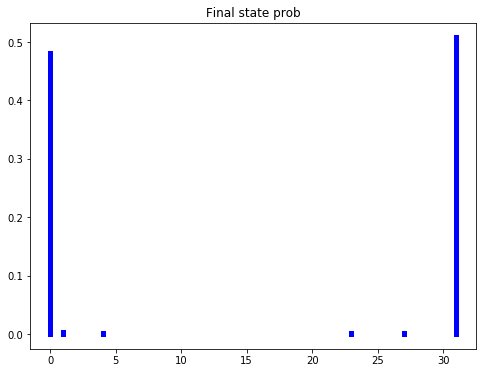

Fidelity =  [0.9836321 0.9805067]


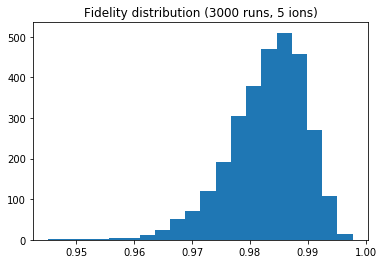

Time elapsed =  0.18189716339111328 s


In [15]:
# 5-qubit circuit

N = 5

# Construct circuits
ideal_bell_circ = Circuit(N)

ideal_state = ideal_bell_circ.H(0).CNOT(0,1).CNOT(0,2) \
            .CNOT(0,3).CNOT(0,4).compute()[0]

bad_bell_circ = Circuit(N)
bad_bell_circ.errors = [0.1, 0.01, 0.1]

final_states = bad_bell_circ.H(0).CNOT(0,1).CNOT(0,2) \
            .CNOT(0,3).CNOT(0,4).compute()

# Probability plot for one run
plt.figure(figsize=(8, 6))
state_prob_plot(final_states[0], title="Final state prob")

print("Fidelity = ", find_fidelities(final_states, ideal_state))

# Repeat a few thousand times, plot fidelity histogram
start = time.time()

runs = 3000
bad_bell_circ.runs = runs
final_states = bad_bell_circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

plt.title(f'Fidelity distribution ({runs} runs, {N} ions)')
plt.hist(fidelities, 20)
plt.show()

print("Time elapsed = ", time.time() - start, "s")


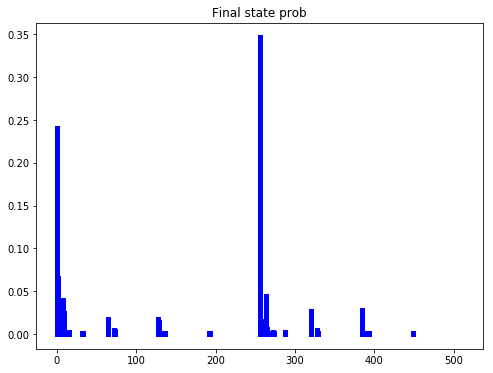

Fidelity =  [0.5723638  0.47124864]


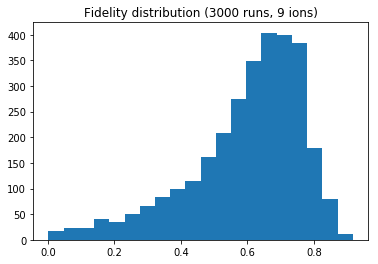

Time elapsed =  41.09772610664368 s
Average fidelity = 0.5981834170576332
Time elapsed =  41.10200619697571 s
10-th percentile fidelity = 0.3502508869747282
90-th percentile fidelity = 0.7761506032493806


In [37]:
# 9 qubits, 160 CNOTs
N = 9

circ = Circuit(N).H(0)

n = 20
for j in range(n):
    for i in range(N-1):
        circ = circ.CNOT(i, N-1)

ideal_state = circ.compute()[0]

# Add errors
err = 0.1
circ.errors = [err, 0.01, err]
final_states = circ.compute()

plt.figure(figsize=(8, 6))
state_prob_plot(final_states[0], title="Final state prob")

print("Fidelity = ", find_fidelities(final_states, ideal_state))

start = time.time()

runs = 3000
circ.runs = runs
final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

plt.title(f'Fidelity distribution ({runs} runs, {N} ions)')
plt.hist(fidelities, 20)
plt.show()

print("Time elapsed = ", time.time() - start, "s")

# You may want to save your results for large circuits (> 10 qubits) due to long runtime

n_gates = (N - 1) * n
fn = f'fidelities_{N}_qubits_{n_gates}_gates.txt'
    
save_fidelities(fidelities, N, n_gates, err, runs, fn)

print(f"Average fidelity = {sum(fidelities)/runs}")
print(f"Time elapsed =  {time.time() - start} s")
print(f'10-th percentile fidelity = {sort(fidelities)[int(runs/10)]}')
print(f'90-th percentile fidelity = {sort(fidelities)[int(9*runs/10)]}')


In [2]:
# # Read the fidelities

# data = read_fidelities('fidelities_10_qubits_180_gates.txt')
# plt.hist(data, 20)
# plt.show()

# sum(read_fidelities('fidelities_10_qubits_180_gates.txt'))

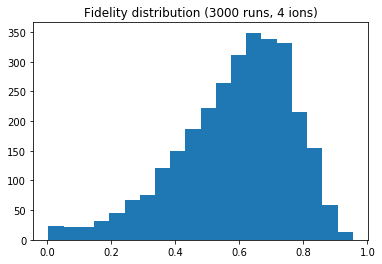

Time elapsed =  1.3890209197998047 s
Average fidelity = 0.5867556951395697
Time elapsed =  1.3948030471801758 s
10-th percentile fidelity = 0.3412877178217407
90-th percentile fidelity = 0.7934299358874882


In [36]:
# 4 qubits, 159 CNOT gates
N = 4

circ = Circuit(N).H(0)

n = 53

for j in range(n):
    for i in range(N-1):
        circ = circ.CNOT(i, N-1)

ideal_state = circ.compute()[0]

# Add errors
err = 0.1
circ.errors = [err, 0.01, err]

start = time.time()

runs = 3000
circ.runs = runs
final_states = circ.compute()
fidelities = find_fidelities(final_states, ideal_state)

plt.title(f'Fidelity distribution ({runs} runs, {N} ions)')
plt.hist(fidelities, 20)
plt.show()

print("Time elapsed = ", time.time() - start, "s")

# Save file

n_gates = (N - 1) * n
fn = f'fidelities_{N}_qubits_{n_gates}_gates.txt'
    
save_fidelities(fidelities, N, n_gates, err, runs, fn)

print(f"Average fidelity = {sum(fidelities)/runs}")
print(f"Time elapsed =  {time.time() - start} s")
print(f'10-th percentile fidelity = {sort(fidelities)[int(runs/10)]}')
print(f'90-th percentile fidelity = {sort(fidelities)[int(9*runs/10)]}')

In [ ]:
# -- Bell state generation for 16 qubits --

In [61]:
N = 16

# Neighbouring CNOTs
circ1 = Circuit(N).Y(0, pi/2)

# Non-neighbouring CNOTs
circ2 = Circuit(N).Y(0, pi/2)

index = 2 ** (N - 1)
for i in range(N - 1):
    circ1 = circ1.CNOT(i, i+1)
    circ2 = circ2.CNOT(0, i+1)
    index += 2 ** (N - 2 - i)

# -- Helper functions --

def bell_state_fid(final_states):
    
    fs = final_states.swapaxes(0, 1)
    fidelities = abs((fs[0] + fs[index])/sqrt(2)) ** 2
    
    return fidelities

def run_circuit(circ, runs):
    
    circ.runs = runs
    final_states = circ.compute()
    
    fidelities = bell_state_fid(final_states)
    
    return fidelities
    

def print_results(N, runs, fidelities):
    # Histogram for fidelities
    plt.title(f'Fidelity distribution ({runs} runs, {N} ions)')
    plt.hist(fidelities, 20)
    plt.show()
    
    print(f"Average fidelity = {sum(fidelities)/runs}")
    print(f'10-th percentile fidelity = {sort(fidelities)[int(runs/10)]}')
    print(f'90-th percentile fidelity = {sort(fidelities)[int(9 * runs/10)]}')

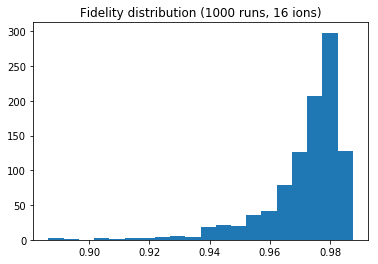

Average fidelity = 0.9717865738470913
10-th percentile fidelity = 0.9546281544455858
90-th percentile fidelity = 0.983104340482295
Time elapsed =  64.44433498382568 s


In [58]:
# Phase error, neighbouring CNOTs
# Without GPU, the circuit runs faster in a loop than in parallel. Will it be the opposite when a GPU is available?
err = 0.05
circ1.errors = [0.0, err, 0.0]
runs = 2

start = time.time()

fidelities = array([])

n1 = 500
for i in range(n1):
    fidelities = concatenate((fidelities, run_circuit(circ1, runs)))

# Save results
filename = f'fidelities_{N}_qubits_{n1 * runs}_runs.txt'

# Summarize results
print_results(N, n1 * runs, fidelities)
print(f"Time elapsed =  {time.time() - start} s")

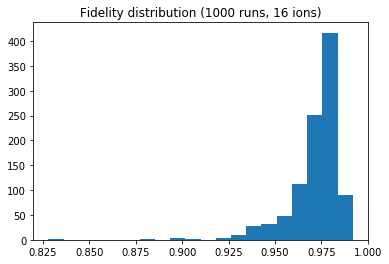

Average fidelity = 0.9718272328546593
10-th percentile fidelity = 0.955626628552188
90-th percentile fidelity = 0.9835301026001129
Time elapsed =  54.75748300552368 s


In [57]:
# Phase error, long-distance CNOTs
err = 0.05
circ2.errors = [0.0, err, 0.0]
runs = 2

start = time.time()

fidelities = array([])

n1 = 500
for i in range(n1):
    fidelities = concatenate((fidelities, run_circuit(circ2, runs)))

# Save results
filename = f'fidelities_{N}_qubits_{n1 * runs}_runs.txt'

# Summarize results
print_results(N, n1 * runs, fidelities)
print(f"Time elapsed =  {time.time() - start} s")

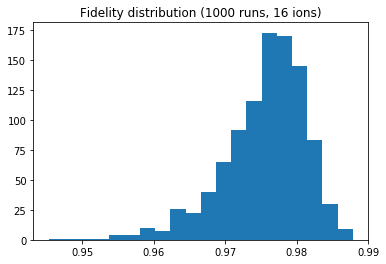

Average fidelity = 0.9754983605040776
10-th percentile fidelity = 0.9678540898744684
90-th percentile fidelity = 0.9818969675407212
Time elapsed =  77.42304921150208 s


In [62]:
# Over-rotation error, neighbouring CNOTs
err = 0.05
circ1.errors = [err, 0.0, 2 * err]
runs = 2

start = time.time()

fidelities = array([])

n1 = 500
for i in range(n1):
    fidelities = concatenate((fidelities, run_circuit(circ1, runs)))

# Save results
filename = f'fidelities_{N}_qubits_{n1 * runs}_runs.txt'

# Summarize results
print_results(N, n1 * runs, fidelities)
print(f"Time elapsed =  {time.time() - start} s")

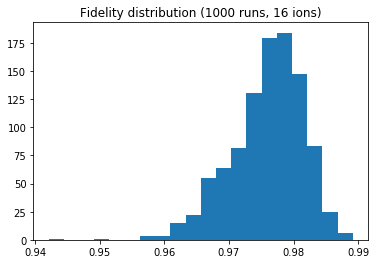

Average fidelity = 0.9759083141972911
10-th percentile fidelity = 0.9680224282104221
90-th percentile fidelity = 0.982342477500641
Time elapsed =  66.08685874938965 s


In [65]:
# Over-rotation error, long-distance CNOTs
err = 0.05
circ2.errors = [err, 0.0, 2 * err]
runs = 2

start = time.time()

fidelities = array([])

n1 = 500
for i in range(n1):
    fidelities = concatenate((fidelities, run_circuit(circ2, runs)))

# Save results
filename = f'fidelities_{N}_qubits_{n1 * runs}_runs.txt'

# Summarize results
print_results(N, n1 * runs, fidelities)
print(f"Time elapsed =  {time.time() - start} s")

In [ ]:
# -- > 19 to 22 qubits, one run only --

In [69]:
N = 22
k = 5       # Number of CNOTs --> (k+1)-qubit Bell state

circ = Circuit(N).Y(0,pi/2)

index = 2 ** (N - 1)
for i in range(N - 1):
    circ = circ.CNOT(i, i+1)
    index += 2 ** (N - 2 - i)


# Add errors
err = 0.1
circ.errors = [0.05, 0.01, err]

start = time.time()
final_states = circ.compute()

# Fidelity
fs = final_states.swapaxes(0, 1)
print("Fidelity = ", abs((fs[0] + fs[index])/sqrt(2)) ** 2)
print("Time elapsed = ", time.time() - start, "s")

# An attempt to save memory
final_states = 0
ideal_state = 0

Fidelity =  [0.95932764 0.95903075]
Time elapsed =  42.94120216369629 s


In [13]:
# FIDELITY / STATE AS A FUNCTION OF TIME
# SMALL ROTATIONS SHOULD HAVE LARGER PERCENTAGE ERRORS